In [2]:
%%time
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import torch
import torch.utils.data as data_utils
import torch.nn as nn

Wall time: 57.7 s


In [3]:
%%time
workdir=os.getcwd()
os.makedirs('fig', exist_ok=True)
fig_dir=workdir+'/fig'
algo_name=['T23', 'S', 'S0', 'S10', 'S20', 'T', 'T0', 'T10', 'T20']
algo={}
for i in range(len(algo_name)):
    algo[i]=pd.read_csv(workdir+'/data/{}.csv'.format(algo_name[i]))

Wall time: 6min 57s


In [4]:
%%time
#cut
ptcut=10
etamin=1.6
etamax=2.9
algo_cut={}
for i in algo:
    sel=algo[i]['genpart_pt']>ptcut
    algo_cut[i]=algo[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])>etamin
    algo_cut[i]=algo_cut[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])<etamax
    algo_cut[i]=algo_cut[i][sel]
    algo_cut[i].dropna(inplace=True)
    algo_cut[i]['genpart_pid'].replace([-11,11],0, inplace=True)
    algo_cut[i]['genpart_pid'].replace([-211,211],1, inplace=True)

Wall time: 1min 28s


In [5]:

# Keep only relevant features and split the data between train and test
from sklearn.model_selection import train_test_split
columns=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean','cl3d_pt']


X_train={}
X_test={}
y_train={}
y_test={}

for i in algo:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(algo_cut[i][columns], algo_cut[i]['genpart_pid'], test_size=0.2)

In [6]:
# keep the pt information for later
X_pt={}
for i in algo:
    X_pt[i]=X_test[i]['cl3d_pt']
    X_test[i]=X_test[i].drop(columns='cl3d_pt')
    X_train[i]=X_train[i].drop(columns='cl3d_pt')
    
columns.remove('cl3d_pt')


In [25]:
#NN parameters
device = torch.device("cpu")
#device = torch.device("cuda:0") 

D_in =X_train[1].shape[1]  # input dimension = number of features
H = 15 # Hidden layer dimension
D_out = 2 # Output dimension= number of classes
batch_size= 64
n_epochs = 30
learning_rate= 1e-6


In [9]:
%%time 
import torch.utils.data as data_utils
tensor_train={}
tensor_test={}
loader_train={}
loader_test={}

for i in algo:
    tensor_train[i] = data_utils.TensorDataset(torch.tensor(X_train[i].values, dtype=torch.float), torch.tensor(y_train[i].values, dtype=torch.long))
    tensor_test[i] = data_utils.TensorDataset(torch.tensor(X_test[i].values, dtype=torch.float), torch.tensor(y_test[i].values, dtype=torch.long))
    loader_train[i] = data_utils.DataLoader(tensor_train[i], batch_size=batch_size, shuffle=False)
    loader_test[i] = data_utils.DataLoader(tensor_test[i], batch_size=batch_size, shuffle=False)
    


Wall time: 11.6 s


In [26]:
%%time
import torch.nn as nn

i=1
y_pred={}
train_losses = []
train_counter = []

network = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),     
    torch.nn.LeakyReLU(0.05),                              
    torch.nn.Linear(H, H),
    torch.nn.LeakyReLU(0.03),
    torch.nn.Linear(H,D_out)
     )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

for epoch in range(n_epochs):
    for j, (data, labels) in enumerate(loader_train[i]):   
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        y_pred[i] = network(data)                             # Forward pass: compute the output class 
        loss = criterion(y_pred[i], labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (j+1) % 2000 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, n_epochs, j+1, len(tensor_train[i])//batch_size, loss.item()))
            
        if (j+1) % 10 == 0:                              # keep track of loss value
            train_losses.append(loss.item())
            train_counter.append(((j+1)*batch_size) + ((epoch)*len(loader_train[i].dataset)))

Epoch [1/30], Step [2000/23500], Loss: 0.6352
Epoch [1/30], Step [4000/23500], Loss: 0.6248
Epoch [1/30], Step [6000/23500], Loss: 0.5494
Epoch [1/30], Step [8000/23500], Loss: 0.5417
Epoch [1/30], Step [10000/23500], Loss: 0.5142
Epoch [1/30], Step [12000/23500], Loss: 0.4900
Epoch [1/30], Step [14000/23500], Loss: 0.4703
Epoch [2/30], Step [2000/23500], Loss: 0.3694
Epoch [2/30], Step [4000/23500], Loss: 0.4269
Epoch [2/30], Step [6000/23500], Loss: 0.3205
Epoch [2/30], Step [8000/23500], Loss: 0.3587
Epoch [2/30], Step [10000/23500], Loss: 0.3476
Epoch [2/30], Step [12000/23500], Loss: 0.3103
Epoch [2/30], Step [14000/23500], Loss: 0.3273
Epoch [3/30], Step [2000/23500], Loss: 0.2464
Epoch [3/30], Step [4000/23500], Loss: 0.3168
Epoch [3/30], Step [6000/23500], Loss: 0.2368
Epoch [3/30], Step [8000/23500], Loss: 0.2555
Epoch [3/30], Step [10000/23500], Loss: 0.2418
Epoch [3/30], Step [12000/23500], Loss: 0.1976
Epoch [3/30], Step [14000/23500], Loss: 0.2249
Epoch [4/30], Step [2000/

Epoch [26/30], Step [2000/23500], Loss: 0.0332
Epoch [26/30], Step [4000/23500], Loss: 0.0890
Epoch [26/30], Step [6000/23500], Loss: 0.0783
Epoch [26/30], Step [8000/23500], Loss: 0.0637
Epoch [26/30], Step [10000/23500], Loss: 0.0280
Epoch [26/30], Step [12000/23500], Loss: 0.0221
Epoch [26/30], Step [14000/23500], Loss: 0.0431
Epoch [27/30], Step [2000/23500], Loss: 0.0331
Epoch [27/30], Step [4000/23500], Loss: 0.0888
Epoch [27/30], Step [6000/23500], Loss: 0.0781
Epoch [27/30], Step [8000/23500], Loss: 0.0635
Epoch [27/30], Step [10000/23500], Loss: 0.0280
Epoch [27/30], Step [12000/23500], Loss: 0.0218
Epoch [27/30], Step [14000/23500], Loss: 0.0428
Epoch [28/30], Step [2000/23500], Loss: 0.0329
Epoch [28/30], Step [4000/23500], Loss: 0.0886
Epoch [28/30], Step [6000/23500], Loss: 0.0779
Epoch [28/30], Step [8000/23500], Loss: 0.0634
Epoch [28/30], Step [10000/23500], Loss: 0.0279
Epoch [28/30], Step [12000/23500], Loss: 0.0215
Epoch [28/30], Step [14000/23500], Loss: 0.0425
Epoc

Text(0,0.5,'Loss')

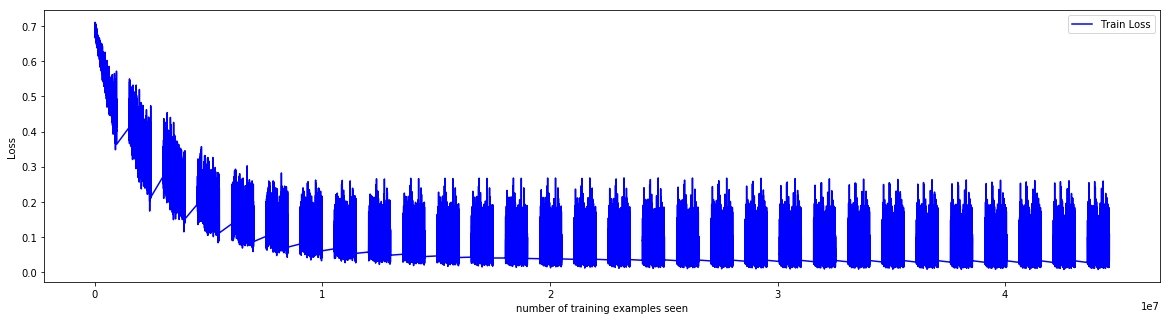

In [27]:
fig = plt.figure(figsize=(20,5))
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Loss')

In [28]:
%%time
correct = 0
total = 0
for data, labels in loader_test[i]:
    outputs = network(data)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network: %d %%' % (100 * correct / total))

Accuracy of the network: 97 %
Wall time: 42.5 s


In [ ]:
predictions={}
for i in algo:
    print(algo_name[i],'\t',booster[i].eval(test[i]))
    predictions[i]=booster[i].predict(test[i])

In [ ]:
for i in algo:
# plot all predictions (both signal and background)
    plt.figure(figsize=(20,5));

    plt.subplot(121);
    plt.hist(predictions[i],bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);

# plot signal and background separately
    plt.subplot(122);
    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);


In [ ]:
plt.figure(figsize=(20,25));
for i in algo:
# plot all predictions (both signal and background)
    
    plt.subplot(4,3,i+1)
# plot signal and background separately
    plt.hist(predictions[i][test[i].get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='signal');
    plt.hist(predictions[i][~(test[i].get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='background');
# make the plot readable
    plt.xlabel('Prediction from BDT',fontsize=12);
    plt.ylabel('Events',fontsize=12);
    plt.title(algo_name[i])
    plt.legend(frameon=False);
plt.savefig(fig_dir+'/predictions.png')

In [ ]:
#plot importance of features for each algo
plt.figure(figsize=(20,30))
for i in algo:
    ax=plt.subplot(5,2,i+1)
    xgb.plot_importance(booster[i],ax,grid=False, title=algo_name[i], importance_type='gain');
plt.savefig(fig_dir+'/importance.png')

In [ ]:
#build ROC

plt.figure(figsize=(10,5))
for i in algo:
    #buildROC(y_test[i], predictions[i])
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc))
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.95,1)
plt.yscale('log')
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate') 
plt.savefig(fig_dir+'/ROC.png')

In [ ]:
def score(ytest, ypred, thr):
    fpr, tpr, threshold = metrics.roc_curve(ytest,ypred)
    roc=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    roc_cut=roc[roc['tpr']>thr];
    score=np.min(roc_cut['fpr']);
    return score

In [ ]:
thr=0.995
scor=[]
for i in algo:
    scor.append(score(y_test[i], predictions[i],thr))
    print('rejection rate for %s at %0.3f threshold=' %(algo_name[i],thr) ,scor[i])

In [ ]:
#plot background efficiency
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(algo_name)), scor)
plt.xticks(np.arange(len(algo_name)), algo_name);
plt.ylabel('Background efficiency')
plt.savefig(fig_dir+'/efficiency.png')

In [ ]:
#CALCULATE ERROR BARS
conf_level=0.99
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi

In [ ]:
#comparison with old 2d3d algo
thr=0.9
#make the comparison
b=algo_cut[0].dropna()
a=b['cl3d_bdteg']
c=np.interp(a, (a.min(), a.max()), (1, 0))

score_old=score(b['genpart_pid'],c,thr)
print('old bdt score:', score_old)

i=0
nbins=20
plt.figure(figsize=(10,5))
plt.hist(c[b['genpart_pid']==0],histtype='step', bins=nbins, label='electron');
plt.hist(c[b['genpart_pid']==1],histtype='step',  bins=nbins, label='pion');
plt.legend()
i=0

fpr, tpr, threshold = metrics.roc_curve(b['genpart_pid'],c)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='old bdteg AUC = %0.4f' %(roc_auc))

fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions[i])
roc_auc = metrics.auc(fpr, tpr)
plt.plot(tpr,np.log(1-fpr), label ='%s AUC = %0.4f' %(algo_name[i],roc_auc))
    
plt.legend(loc = 'lower left')
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.8,1)
    #plt.ylim(0.6,1.05)
plt.xlabel('efficiency')
plt.ylabel('Log Rejection Rate')  
plt.savefig(fig_dir+'/old.png')

In [ ]:
%%time
#plot score
%matplotlib inline
import matplotlib.ticker as ticker
fig=plt.figure(figsize=(15,20))
thr=0.95
nbins=10
conf_level=0.682689492137
pred_pt={}
y_test_pt={}
bins_pt={}
score_pt={}
y_err_pt={}
#faire les bins après entrainement du bdt
#--> predictions[i] vs y_test[i]
#predictions[i]=booster[i].predict(test[i])--> binner test[i]
# --> binner X_test[i] et y_test[i]
for i in algo:
    
    pt_max=np.max(X_pt[i])
    pt_min=np.min(X_pt[i])
    range_pt=pt_max-pt_min
    bins_pt=[]
    score_pt=[]
    y_err_pt=[]
    y_err_pt_lo=[]
    y_err_pt_hi=[]
    pred_pt={}
    y_test_pt={}
    
    
    X_test[i]['abseta']=np.abs(X_test[i]['cl3d_eta'])
    eta_max=np.max(X_test[i]['abseta'])
    eta_min=np.min(X_test[i]['abseta'])
    range_eta=eta_max-eta_min
    bins_eta=[]
    score_eta=[]
    y_err_eta=[]
    y_err_eta_lo=[]
    y_err_eta_hi=[]
    pred_eta={}
    y_test_eta={}
    for j in range(nbins):
        #make sure last bins are not too small
        n_min=X_pt[i].shape[0]/(1.4*nbins)
        
        sel=(X_pt[i] >= (pt_min+j*range_pt/nbins)) & (X_pt[i] < (pt_min+(j+1)*range_pt/nbins))
        
        if X_pt[i][sel].shape[0]>n_min:
            bins_pt.append(((pt_min+j*range_pt/nbins)+(pt_min+(j+1)*range_pt/nbins))/2)
           
            pred_pt[j]=predictions[i][sel]
            
            y_test_pt[j]=y_test[i][sel]
        else: 
            
            bins_pt.append(((pt_min+j*range_pt/nbins)+(pt_max))/2)
            sel=(X_pt[i] >= (pt_min+j*range_pt/nbins))
            pred_pt[j]=predictions[i][sel]
            y_test_pt[j]=y_test[i][sel]
            
            break       

    for j in range(len(pred_pt)): 
        
        score_pt.append(score(y_test_pt[j], pred_pt[j],thr))
        #print('rejection rate for pt bin %d at %0.3f threshold=' %(j+1,thr),  score_pt[j])
        
        lo,hi=error(y_test_pt[j].shape[0], score(y_test_pt[j], pred_pt[j], thr), conf_level)
        
        y_err_pt_lo.append(lo)
        y_err_pt_hi.append(hi)
        
    
    for j in range(nbins):
        
        bins_eta.append(((eta_min+j*range_eta/nbins)+(eta_min+(j+1)*range_eta/nbins))/2)
        sel=(X_test[i]['abseta'] > (eta_min+j*range_eta/nbins)) & (X_test[i]['abseta'] < (eta_min+(j+1)*range_eta/nbins))
        
        pred_eta[j]=predictions[i][sel]
        
        y_test_eta[j]=y_test[i][sel]
        score_eta.append(score(y_test_eta[j], pred_eta[j],thr))
        lo, hi=error(y_test_eta[j].shape[0], score(y_test_eta[j], pred_eta[j], thr), conf_level)
        y_err_eta_lo.append(lo)
        y_err_eta_hi.append(hi)
        
        
        
    y_err_pt=[y_err_pt_lo, y_err_pt_hi]
    y_err_eta=[y_err_eta_lo, y_err_eta_hi]
        
    plt.subplot(411);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('pt');
    plt.ylim(-0.001,0.01)
    plt.xlim(right=130)
    plt.legend()
    
    plt.subplot(412);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i]);
    plt.ylabel('Background efficiency score');
    plt.xlabel('eta');
    plt.ylim(-0.001,0.006)
    plt.legend()
    plt.xlim(right=3.0)
    
    plt.subplot(413);
    plt.errorbar(bins_pt, score_pt, y_err_pt, label=algo_name[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('pt');
    plt.xlim(right=130)
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    plt.ylim(0.000008,0.03)
    plt.legend()
    
    plt.subplot(414);
    plt.errorbar(bins_eta, score_eta, y_err_eta, label=algo_name[i]);
    plt.ylabel('Logit Background efficiency score');
    plt.xlabel('eta');
    plt.yscale('logit')
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(subs=[0]));
    plt.ylim(0.000008,0.03)
    plt.xlim(right=3.0)
    plt.legend()
    
   
    
    plt.suptitle('Background efficiency at %0.3f signal efficiency at %0.2f CL for different algorithms' %(thr, conf_level), fontsize=14)
    plt.savefig(fig_dir+'/Algo_comparison.png')